![](https://www.ieseg.fr/wp-content/uploads/IESEG-Logo-2012-rgb.jpg)

## Assignment-Survival analysis
-Harikrishnan Gopalakrishnan

## Survival Analysis 


Survival Analysis is used to estimate the lifespan of a particular population under study. It is also called ‘Time to Event’ Analysis as the goal is to estimate the time for an individual or a group of individuals to experience an event of interest

In this problem,the objective is to analyse the time to default using Kaplan Meier mpdel and Cox Proportional Hazard Model (non time-varying).

References:
- https://towardsdatascience.com/survival-analysis-part-a-70213df21c2e

In [1]:
#pip install lifelines

In [1]:
#from lifelines import KaplanMeierFitter
import lifelines

# Loading the required libraries
import pandas as pd
import numpy as np
from numpy import where
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from category_encoders import *
from collections import Counter


sns.set(style='white', context='notebook', palette='deep')
pd.options.display.max_columns = 100

## Load the Data

In [2]:
credit = pd.read_csv('./Data/mortgage.csv')

In [3]:
print("the shape of the data :" ,credit.shape)

the shape of the data : (622489, 23)


In [4]:
credit.head()

id  time  orig_time  first_time  mat_time  balance_time   LTV_time  \
0   1    25         -7          25       113      41303.42  24.498336   
1   1    26         -7          25       113      41061.95  24.483867   
2   1    27         -7          25       113      40804.42  24.626795   
3   1    28         -7          25       113      40483.89  24.735883   
4   1    29         -7          25       113      40367.06  24.925476   

   interest_rate_time  hpi_time  gdp_time  uer_time  REtype_CO_orig_time  \
0                 9.2    226.29  2.899137       4.7                    0   
1                 9.2    225.10  2.151365       4.7                    0   
2                 9.2    222.39  2.361722       4.4                    0   
3                 9.2    219.67  1.229172       4.6                    0   
4                 9.2    217.37  1.692969       4.5                    0   

   REtype_PU_orig_time  REtype_SF_orig_time  investor_orig_time  \
0                    0                    1                   0   
1                    0                    1                   0   
2                    0                    1                   0   
3                    0                    1                   0   
4                    0                    1                   0   

   balance_orig_time  FICO_orig_time  LTV_orig_time  Interest_Rate_orig_time  \
0            45000.0             715           69.4                      9.2   
1            45000.0             715           69.4                      9.2   
2            45000.0             715           69.4                      9.2   
3            45000.0             715           69.4                      9.2   
4            45000.0             715           69.4                      9.2   

   hpi_orig_time  default_time  payoff_time  status_time  
0          87.03             0            0            0  
1          87.03             0            0            0  
2          87.03             0            0            0  
3          87.03             0            0            0  
4          87.03             0            0            0

## Data Preprocessing

In [5]:
#check the missing values
credit.isna().sum()

id                           0
time                         0
orig_time                    0
first_time                   0
mat_time                     0
balance_time                 0
LTV_time                   270
interest_rate_time           0
hpi_time                     0
gdp_time                     0
uer_time                     0
REtype_CO_orig_time          0
REtype_PU_orig_time          0
REtype_SF_orig_time          0
investor_orig_time           0
balance_orig_time            0
FICO_orig_time               0
LTV_orig_time                0
Interest_Rate_orig_time      0
hpi_orig_time                0
default_time                 0
payoff_time                  0
status_time                  0
dtype: int64

<b>LTV_time : Loan to value ratio at observation time(%) has 270 null or missing values.

In [6]:
# Filling them with NA values with mean
credit['LTV_time'] = credit.LTV_time.fillna(credit.LTV_time.mean())

In [8]:
# To Evaluate whether the time to default for borrowers with low outstanding balance at origination time (30% quantile) 
credit['balance_orig_time'].quantile(0.3)

credit['low_bal'] = 0

credit.loc[(credit['balance_orig_time'] < credit['balance_orig_time'].quantile(0.3)),'low_bal'] = 1

In [9]:
# Converting Episodic Data to Static Data
credit_static = credit.groupby("id").agg(np.max).reset_index()

In [10]:
print("The shape of the mortgage static data :" ,credit_static.shape)

The shape of the mortgage static data : (50000, 24)


## Exploratory Data Analysis

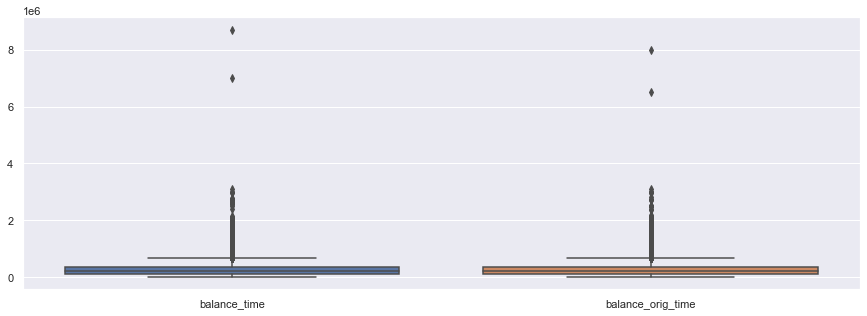

In [11]:
#to check the outliers for balance_tim and balance_orig_time
sns.set(rc={'figure.figsize':(15,5)})
bp2 = sns.boxplot(data = credit_static[['balance_time', 'balance_orig_time']])

the balance time and balance orig_time columns has some outliers

<AxesSubplot:ylabel='default_time'>

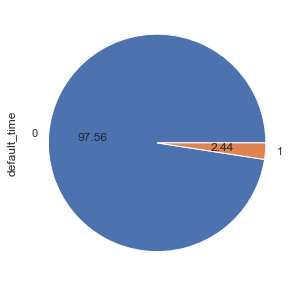

In [12]:
# Analyzing the Status Time
credit["default_time"].value_counts().plot.pie(autopct='%.2f', figsize=(15,5))

The proportion of deafult time is 97.56% for the time for deafaulters and 2.44% for non defaulters

## Plot the Lifelines for clients

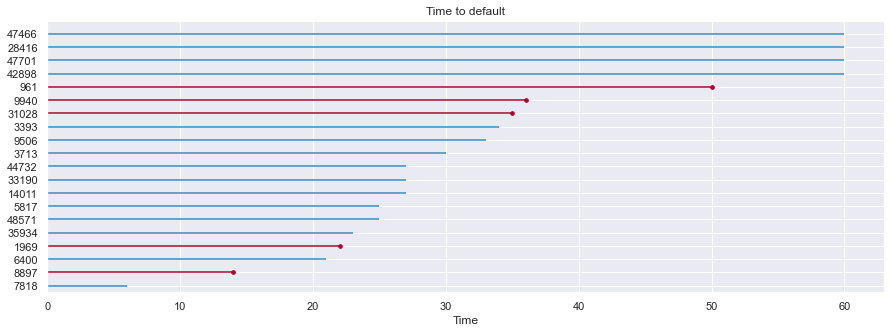

In [13]:
from lifelines.plotting import plot_lifetimes

df_samp = credit_static.sample(20)
ax = plot_lifetimes(df_samp["time"], event_observed=df_samp["default_time"])
ax.set_xlabel("Time")
ax.set_title("Time to default")
plt.show()

we can observe that the red colour lines represent the client with balance amounts are about to default

## Kaplan Meier Model

The Kaplan-Meier estimator is a non-parametric technique of estimating and plotting the survival probability as a function of time.

In this case we use this modelt to predict and plot the survival probability of clients with respect to timeline

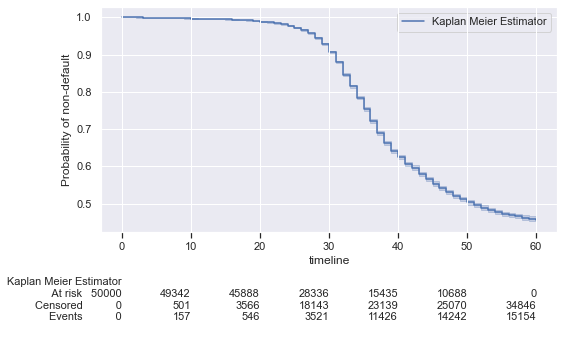

In [14]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
# fit on static data: TIME indicates the last observed timestep, TARGET indicates whether the customer defaulted
kmf.fit(credit_static['time'], credit_static['default_time'], label='Kaplan Meier Estimator')

# plot survival function
ax = kmf.plot_survival_function(at_risk_counts=True,figsize=(8,5))
ax.set_ylabel('Probability of non-default')
plt.show()

<b>The horizontal axis (x-axis) represents time in days, and the vertical axis (y-axis) shows the probability of surviving or the proportion of people surviving.

31.0


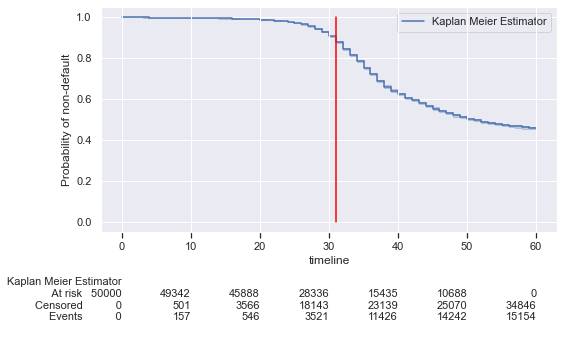

In [15]:
# Median default_time?
median_default = credit_static.query("low_bal==1")["time"].median()
print(median_default)

# add to plot
ax = kmf.plot_survival_function(at_risk_counts=True,figsize=(8,5))
ax.set_ylabel('Probability of non-default')
plt.plot([median_default, median_default], [0,1], 'k-', c="red")
plt.show()

In [16]:
kmf.event_table

removed  observed  censored  entrance  at_risk
event_at                                                
0.0             0         0         0     50000    50000
1.0            22         3        19         0    50000
2.0            37         5        32         0    49978
3.0            57        14        43         0    49941
4.0            56        25        31         0    49884
...           ...       ...       ...       ...      ...
56.0          223        58       165         0     8996
57.0          231        49       182         0     8773
58.0          245        77       168         0     8542
59.0          293        53       240         0     8297
60.0         8004        43      7961         0     8004

[61 rows x 5 columns]

<AxesSubplot:xlabel='timeline'>

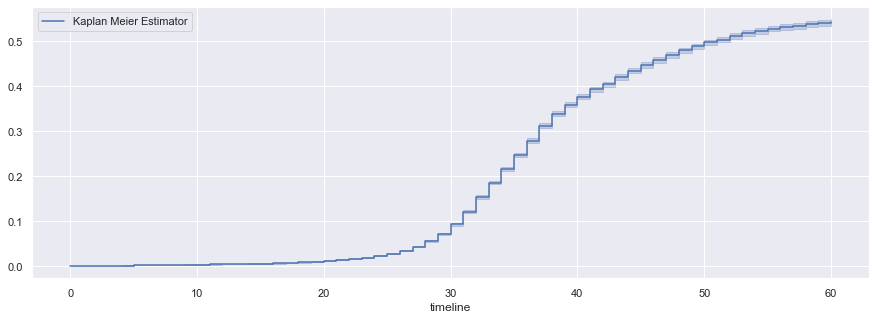

In [17]:
# plot cumulative hazard function
kmf.plot_cumulative_density()

In [18]:
# "predict" probability to default at time 50

# 1 - probability of non-default at time 50
print(1 - kmf.predict(50))

# 1 - probability of non-default at time 25
print(1 - kmf.predict(25))

0.49651115609746754
0.027535396793506917


compare the probability of survival after 25 and 50 months for the two groups:
    For 25 months the probability of survival is 2.7%.
    For 50 months the probability of survival is 2.7%.


<AxesSubplot:ylabel='low_bal'>

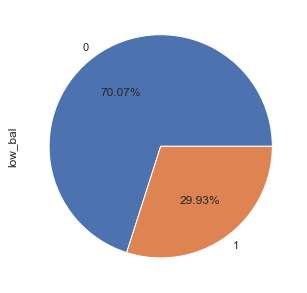

In [19]:
# display pie chart gender
credit["low_bal"].value_counts().plot.pie(autopct='%.2f%%', figsize=(5,8))

70.07% of the clients with low balance are about to default and 29.93% of the clients are not about to default.

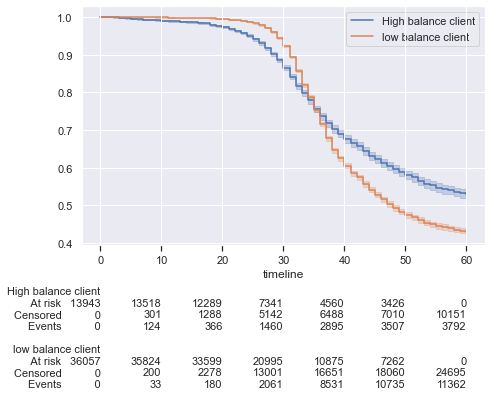

In [20]:
# Compare two groups

kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

fig, ax = plt.subplots(1,1 , figsize=(7,6))

# subset data
df1 = credit_static.loc[credit_static["low_bal"] == 1,:]
df2 = credit_static.loc[credit_static["low_bal"] == 0,:]

# fit subset gender = male
ax = kmf1.fit(df1['time'], df1['default_time'], label='High balance client').plot_survival_function(ax=ax)

# fit subset gender = female
ax = kmf2.fit(df2['time'], df2['default_time'], label='low balance client').plot_survival_function(ax=ax)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf1, kmf2, ax=ax)
plt.tight_layout()

## Logrank Test

The log rank test is a popular test to test the null hypothesis of no difference in survival between two or more independent groups. The test compares the entire survival experience between groups and can be thought of as a test of whether the survival curves are identical (overlapping) or not.

References:
- https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_survival/BS704_Survival5.html#:~:text=The%20log%20rank%20test%20is,identical%20(overlapping)%20or%20not.

In [21]:
# Perform logrank test to assess whether there is a difference between low balance client and high balance client in time to default

from lifelines.statistics import logrank_test

# Null-Hypothesis: No difference between the two groups
res = logrank_test(df1['time'], df2['time'], event_observed_A=df1['low_bal'],event_observed_B=df2['low_bal'])

# We can reject the Null-Hypothesis (p < 0.05)
res.summary 

test_statistic    p  -log2(p)
0    38017.288893  0.0       inf

The p-value = 0,there is difference between two groups

## Cox Proportional Hazard Model (time varying)

 `Cox Proportional Hazard Model`is a regression model used as an alternative approach, which works for both quantitative predictor variables and for categorical variables.It estimates the relationship between survival time and covariates.

It assumes one underlying hazard function for all observations with individual scaling,It can be extended to fit covariates varying with time.

Ref:Professor Philipp Borchert notes -3 Survival Analysis

In [22]:
credit_static.columns

Index(['id', 'time', 'orig_time', 'first_time', 'mat_time', 'balance_time',
       'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time',
       'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time',
       'investor_orig_time', 'balance_orig_time', 'FICO_orig_time',
       'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time',
       'default_time', 'payoff_time', 'status_time', 'low_bal'],
      dtype='object')

In [23]:
credit_static.dtypes

id                           int64
time                         int64
orig_time                    int64
first_time                   int64
mat_time                     int64
balance_time               float64
LTV_time                   float64
interest_rate_time         float64
hpi_time                   float64
gdp_time                   float64
uer_time                   float64
REtype_CO_orig_time          int64
REtype_PU_orig_time          int64
REtype_SF_orig_time          int64
investor_orig_time           int64
balance_orig_time          float64
FICO_orig_time               int64
LTV_orig_time              float64
Interest_Rate_orig_time    float64
hpi_orig_time              float64
default_time                 int64
payoff_time                  int64
status_time                  int64
low_bal                      int64
dtype: object

In [24]:
# select variables used in previous model + time varying variables
credit_tv = pd.merge(credit[["id", "default_time", "hpi_time", "gdp_time", "uer_time", "balance_time",
"interest_rate_time", "FICO_orig_time", "LTV_time", "low_bal","first_time"]], credit_static[["id", "time"]]
.rename(columns={"time":"time_obs"}), on="id", how="inner") 



In [25]:
credit_tv.dtypes

id                      int64
default_time            int64
hpi_time              float64
gdp_time              float64
uer_time              float64
balance_time          float64
interest_rate_time    float64
FICO_orig_time          int64
LTV_time              float64
low_bal                 int64
first_time              int64
time_obs                int64
dtype: object

In [26]:
#Ref:https://www.geeksforgeeks.org/lambda-filter-python-examples/#:~:text=We%20can%20use%20Lambda%20function,and%20a%20list%20as%20arguments.
#Filtering with clients which has more than one occurence
credit_2 = credit_tv.groupby('id').filter(lambda x: len(x) > 1)

In [27]:
from lifelines import CoxTimeVaryingFitter

# Note: credit_tv contains both time varying and static variables 
ctv = CoxTimeVaryingFitter()
ctv.fit(credit_2, id_col="id", event_col="low_bal", start_col="first_time", stop_col="time_obs", show_progress=True)
ctv.summary

Iteration 8: norm_delta = 0.00000, step_size = 1.00000, ll = -2097135.27778, newton_decrement = 0.00000, seconds_since_start = 22.9Convergence completed after 8 iterations.


coef  exp(coef)      se(coef)  coef lower 95%  \
covariate                                                               
default_time        1.491326   4.442984  1.721272e-02        1.457590   
hpi_time            0.004963   1.004976  1.818912e-04        0.004607   
gdp_time            0.003550   1.003556  1.503634e-03        0.000603   
uer_time           -0.164250   0.848530  2.460713e-03       -0.169073   
balance_time       -0.000024   0.999976  6.493183e-08       -0.000024   
interest_rate_time  0.051324   1.052664  1.164325e-03        0.049042   
FICO_orig_time     -0.000924   0.999076  3.396917e-05       -0.000991   
LTV_time            0.013129   1.013215  9.679173e-05        0.012939   

                    coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                      
default_time              1.525063             4.295594             4.595431   
hpi_time                  0.005320             1.004617             1.005334   
gdp_time                  0.006497             1.000603             1.006518   
uer_time                 -0.159427             0.844448             0.852632   
balance_time             -0.000024             0.999976             0.999976   
interest_rate_time        0.053606             1.050265             1.055069   
FICO_orig_time           -0.000858             0.999010             0.999143   
LTV_time                  0.013318             1.013023             1.013407   

                    cmp to           z              p    -log2(p)  
covariate                                                          
default_time           0.0   86.640931   0.000000e+00         inf  
hpi_time               0.0   27.286677  6.104723e-164  542.186282  
gdp_time               0.0    2.361044   1.822359e-02    5.778049  
uer_time               0.0  -66.748823   0.000000e+00         inf  
balance_time           0.0 -367.217067   0.000000e+00         inf  
interest_rate_time     0.0   44.080664   0.000000e+00         inf  
FICO_orig_time         0.0  -27.206373  5.459815e-163  539.025427  
LTV_time               0.0  135.638253   0.000000e+00         inf

In [28]:
# inspect p-values
round(ctv.summary['p'], 4)

covariate
default_time          0.0000
hpi_time              0.0000
gdp_time              0.0182
uer_time              0.0000
balance_time          0.0000
interest_rate_time    0.0000
FICO_orig_time        0.0000
LTV_time              0.0000
Name: p, dtype: float64

<AxesSubplot:xlabel='log(HR) (95% CI)'>

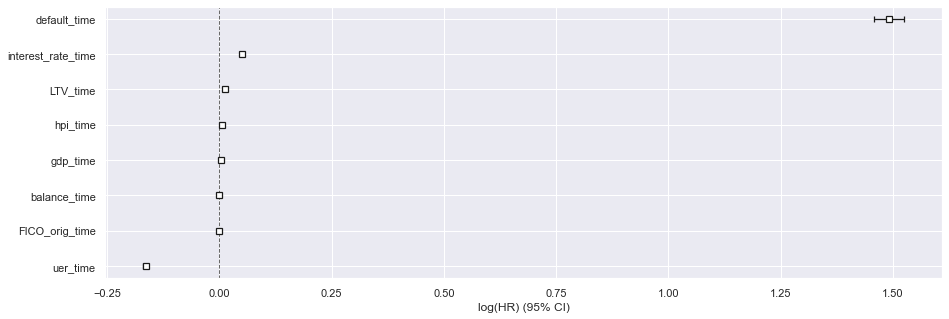

In [29]:
ctv.plot()

In [30]:
# print parameter values
print(round(ctv.params_, 6))

covariate
default_time          1.491326
hpi_time              0.004963
gdp_time              0.003550
uer_time             -0.164250
balance_time         -0.000024
interest_rate_time    0.051324
FICO_orig_time       -0.000924
LTV_time              0.013129
dtype: float64


# interpretation

In [31]:
# Interpretation: 
print('\n The outstanding balance at origination time decreases the probability to default time by {:.3f}%'.format((np.exp(0.000020) - 1)*100))
print('\n The unemployment rate at origination time decreases the probability to default time by {:.3f}%'.format((np.exp(0.715506) - 1)*100))
print('\n The house price index at origination time decreases the probability to default time by {:.3f}%'.format((np.exp(0.015452) - 1)*100))
print('\n The GDP growth at origination time increases the probability to default time by {:.3f}%'.format((np.exp(1.162542) - 1)*100))


 The outstanding balance at origination time decreases the probability to default time by 0.002%

 The unemployment rate at origination time decreases the probability to default time by 104.522%

 The house price index at origination time decreases the probability to default time by 1.557%

 The GDP growth at origination time increases the probability to default time by 219.805%


<AxesSubplot:>

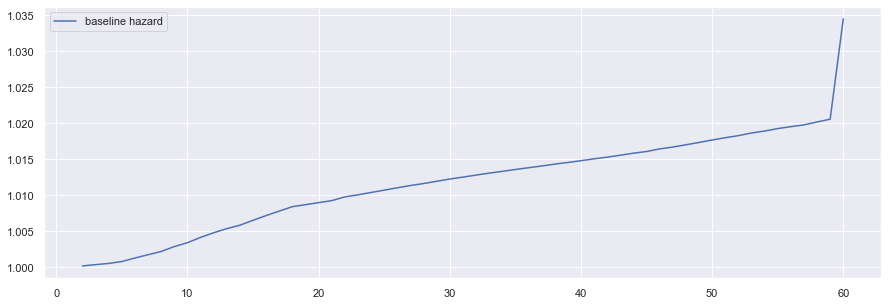

In [32]:
np.exp(ctv.baseline_cumulative_hazard_).plot()